In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, in_context_from_samples, test_prompt_from_samples, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_proper"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 73,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 108,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 92,
 'start_cap': 126,
 'start_consonant': 171,
 'start_lower': 74,
 'start_the': 57,
 'start_vowel': 29}


In [2]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["proper_noun"]
tags_false = []
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common)

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

32 168


In [3]:
pprint(positives)

[{'input': 'python is a popular programming language.',
  'label': True,
  'tags': ['proper_noun',
           'gpt4',
           'sentence',
           'even_words',
           'short',
           'start_consonant',
           'all_lower',
           'start_lower',
           'shared_sample']},
 {'input': 'Tokyo is the capital city of Japan.',
  'label': True,
  'tags': ['proper_noun',
           'gpt4',
           'city',
           'sentence',
           'start_consonant',
           'long',
           'start_cap',
           'odd_words']},
 {'input': 'THE EARTH ROTATES ON ITS AXIS.',
  'label': True,
  'tags': ['all_upper',
           'proper_noun',
           'gpt4',
           'sentence',
           'even_words',
           'short',
           'nature',
           'start_consonant',
           'start_cap',
           'start_the',
           'shared_sample']},
 {'input': 'javaScript is essential for web development.',
  'label': True,
  'tags': ['proper_noun',
           'gpt4',
  

In [4]:
pprint(negatives)

[{'input': 'the river flows silently through the valley.',
  'label': False,
  'tags': ['gpt4',
           'sentence',
           'nature',
           'start_consonant',
           'long',
           'odd_words',
           'all_lower',
           'start_the',
           'start_lower']},
 {'input': 'gentle raindrops tapping on the window',
  'label': False,
  'tags': ['all_lower',
           'gpt4',
           'even_words',
           'short',
           'fragment_subject',
           'start_lower',
           'start_consonant']},
 {'input': 'rainy days are perfect for cozy reading.',
  'label': False,
  'tags': ['odd_words',
           'all_lower',
           'gpt4',
           'sentence',
           'start_lower',
           'start_consonant',
           'long']},
 {'input': 'City lights twinkling in the night sky',
  'label': False,
  'tags': ['odd_words',
           'gpt4',
           'city',
           'fragment_subject',
           'start_consonant',
           'long',
          

In [5]:
def write_test_data(positives, negatives, samples_per_label):
    num_test_samples = min(len(positives), len(negatives)) - samples_per_label

    in_context_samples = positives[:samples_per_label] + negatives[:samples_per_label]
    in_context_prompt = in_context_from_samples(in_context_samples)
    with open(output_dir / f"in_context_prompt_{samples_per_label}.txt", "w") as f:
        f.write(in_context_prompt)

    test_positives = positives[samples_per_label:][:num_test_samples]
    test_negatives = negatives[samples_per_label:][:num_test_samples]
    test_prompt, test_samples = test_prompt_from_samples(test_positives, test_negatives)
    with open(output_dir / f"test_prompt_{samples_per_label}.txt", "w") as f:
        f.write(test_prompt)
    json.dump(test_samples, open(output_dir / f"test_samples_{samples_per_label}.json", "w"), indent=2)

In [19]:
sample_counts = [3, 5, 10, 15]
response_jsons = []
for c in sample_counts:
    write_test_data(positives, negatives, c)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:93: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:94: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:97: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:98: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [20]:
sample_counts = [3, 5, 10, 15]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [21]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.9827586206896551,
  'correct': 57,
  'corrupted': 0,
  'in_context_count': 3,
  'incorrect': 1,
  'mismatch': 0,
  'total': 58},
 {'accuracy': 0.9629629629629629,
  'correct': 52,
  'corrupted': 0,
  'in_context_count': 5,
  'incorrect': 2,
  'mismatch': 0,
  'total': 54},
 {'accuracy': 0.9772727272727273,
  'correct': 43,
  'corrupted': 0,
  'in_context_count': 10,
  'incorrect': 1,
  'mismatch': 0,
  'total': 44},
 {'accuracy': 0.9705882352941176,
  'correct': 33,
  'corrupted': 0,
  'in_context_count': 15,
  'incorrect': 1,
  'mismatch': 0,
  'total': 34}]


In [22]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                   correct  mismatch  incorrect  corrupted  test_total
in_context_count                                                      
3.155172          0.982759       0.0   0.017241        0.0    0.950820
5.648148          0.962963       0.0   0.037037        0.0    0.885246
13.863636         0.977273       0.0   0.022727        0.0    0.721311
26.911765         0.970588       0.0   0.029412        0.0    0.557377


Text(0.5, 1.0, 'Complete sentences vs Sentence fragments (n=61, T=1)')

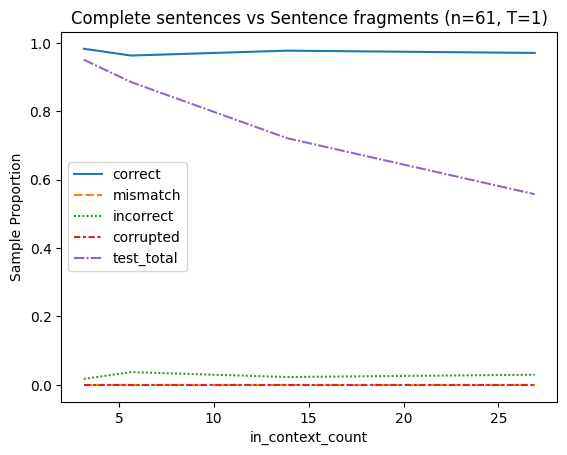

In [23]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

for col in df.columns:
    if col == "total":
        df[col] /= total_samples
    else:
        df[col] /= df["total"]
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Complete sentences vs Sentence fragments (n={total_samples}, T=1)")